# Datascience Capstone project - Usage of Foursquare Data to compare popular venues of US and German Cities

by Andreas Ediger


## 1. Introduction: Description of the problem and a discussion of the background. 

This analysis shall compare venues of US and German Cities. It shall determine general live-style differences between US and German citizens.
For example it can reveal differences or similarites between US and German citizens by extracting the density of certain venue groups. Imagine a certain venue category like coffee shops occurs much more often in Germany, we can conclude that Germany is the bigger Coffe-Drinker Nation. Or in the US, parks are much more frequent, this can show that US people like to spend their leasure time in Parks more, compared to Germans.
These are just two imaginary examples but the analysis will find this kind of outcome.
Another example can be popularity of venue categories. E.g. we could find out that bakeries are extremely popular for US citizens. This could encourage German bakers to start their business in the US (thinking about strong German Bakery-Tradition)

This analysis will be of particular interest of US or German people who plan to visit the other country, or even plan a longer stay up to migration.
Also companies who want to expand their business in the other country will benefit from this analysis.

## 2. Description of the data and how it will be used to solve the problem.

The data used for the analysis will mainly be retreived from the Foursquare API. This way we can geospatial data from specific German and US cities. Via the API we can get the occurence of particular venue categories such as Parks or Coffee-Shops. 
This data can be normalized, e.g. by diving a category occurence by the total number of venues in a specific area. This way we can avoid biasing by US or German citizens using Foursquare more.
The Foursquare Data will be enriched by publically available data such as demographics, city size or income structure.



## 3. Analysis

In this section we will do all parts of the actual analysis

### 3.1 Data collection

In this section we will retreive the data that will be examined in the further analysis. This data will come from Foursquare. As German and US cities shall be compared, venues from two major US cities and two major German cities will be retreived.
First, the Foursquare API will be initialized:

In [425]:
# @hidden_cell
CLIENT_ID = 'HM1IR3OCOYN0PNTVI4TWSRPUSFK1HNBEGIYLNQDDDRJUSYJB' # your Foursquare ID
CLIENT_SECRET = 'YLRFPK0W5NAP3L4FYQYFJJTIZHKEY5BFNR3DGNUXJIFYYOBH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Now, we will try to retreive the venues around a specific location. The location we choose is Berlin Alexanderplatz, a popular place in Berlin. We will search in a 500 m radius around Alexanderplatz. We will use the "explore" endpoint of the foursquare API

In [71]:
import requests
import pandas as pd

lat=52.520018
lng=13.412597
radius=500
LIMIT=100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']

Let's examine the some of the venues to get an impression what is around Alexanderplatz

In [72]:
for i in range(0,20):
    print('Venue %i is a %s called %s and has the venue id %s' % (i+1,results[i]['venue']['categories'][0]['name'],results[i]['venue']['name'],results[i]['venue']['id']))

Venue 1 is a Cosmetics Shop called LUSH and has the venue id 4c28ad7997d00f47212d40ea
Venue 2 is a Hotel called Motel One Berlin-Alexanderplatz and has the venue id 54aa71d0498e077a285b5eed
Venue 3 is a Historic Site called Ruine der Franziskaner-Klosterkirche and has the venue id 4adcda7ff964a520eb4721e3
Venue 4 is a Sporting Goods Shop called Decathlon and has the venue id 5535f234498efc81eb55d6e6
Venue 5 is a Bike Rental / Bike Share called Fat Tire Bike Tours and has the venue id 4bb8541f1261d13a118fe898
Venue 6 is a Gift Shop called Flying Tiger and has the venue id 588875294745863ba6709dcf
Venue 7 is a Burger Joint called momotaro tavern and has the venue id 598f4c672aff3159d8a373b2
Venue 8 is a Scenic Lookout called Berliner Fernsehturm and has the venue id 4adcda7cf964a520504721e3
Venue 9 is a Tour Provider called Alternative Berlin Tour and has the venue id 4d049a6c37036dcb560112fb
Venue 10 is a Clothing Store called UNIQLO and has the venue id 5ba4b8d31ffed7002cd2e17e
Venue 1

So, we know what is around Alexanderplatz. Now, let's also get the rating of the according venue using the "venue" endpoint of the foursquare API.
Unfortunately this is a "premium" call, it is limited to 500 calls per day for the free account, so we cannot use it extensively

In [76]:
for i in range(0,10):
    url2 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(results[i]['venue']['id'],CLIENT_ID,CLIENT_SECRET,VERSION)
    venue_result = requests.get(url2).json()
    print('Venue %i is a %s called %s and has the rating of %f' % (i+1,results[i]['venue']['categories'][0]['name'],results[i]['venue']['name'],venue_result['response']['venue']['rating']))

Venue 1 is a Cosmetics Shop called LUSH and has the rating of 8.900000
Venue 2 is a Hotel called Motel One Berlin-Alexanderplatz and has the rating of 8.700000
Venue 3 is a Historic Site called Ruine der Franziskaner-Klosterkirche and has the rating of 8.400000
Venue 4 is a Sporting Goods Shop called Decathlon and has the rating of 8.300000
Venue 5 is a Bike Rental / Bike Share called Fat Tire Bike Tours and has the rating of 9.100000
Venue 6 is a Gift Shop called Flying Tiger and has the rating of 8.700000
Venue 7 is a Burger Joint called momotaro tavern and has the rating of 8.300000
Venue 8 is a Scenic Lookout called Berliner Fernsehturm and has the rating of 8.000000
Venue 9 is a Tour Provider called Alternative Berlin Tour and has the rating of 8.000000
Venue 10 is a Clothing Store called UNIQLO and has the rating of 8.000000


Now, let's define a function to retreive the venues from some major German and US cities.

In [289]:
import requests
import pandas as pd

def getVenues(name, lat, long, radius=5000,LIMIT=5000):
    venues_list=[]
    
    #print(name)
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long, 
            radius, 
            LIMIT)
            
        # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    #print(results.shape)
        # return only relevant information for each nearby venue
    venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',                  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category','Venue id']
    
    return(nearby_venues)

Let's get the data. Unfortunately, the "explore" endpoint is limited to 100 results per call, so for one city we will define multiple long/lat pairs and combine the results afterwards.
To collect the entire city data, we will loop over the 400 GPS positions within Berlin.

In [311]:
import numpy as np

lat_nw=52.589423
long_nw=13.280060

lat_ne=52.589423
long_ne=13.504031


lat_sw=52.427776
long_sw=13.280060

lat_se=52.427776
long_se=13.504031

lat_step=(lat_nw-lat_sw)/20
lat_iter=np.arange(lat_sw,lat_nw,lat_step)

long_step=(long_se-long_sw)/20
long_iter=np.arange(long_sw,long_se,long_step)

name='Berlin'
#radius=500
#LIMIT=100

Berlin_venues = pd.DataFrame(columns=['City',                  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category','Venue id'])

for lat_ in lat_iter:
    for long_ in long_iter:
        print('Retrieving venues for GPS position: %f, %f' %(lat_,long_))
        try:
            #temp_venues=getVenues(name,lat_,long_,radius=500,LIMIT=100)
            temp_venues=getVenues(name,lat_,long_,radius=500,LIMIT=100)
            #print('       ' , temp_venue.iloc[[0]]['Venue'])
            #print(temp_venue)
            #Berlin_venues=pd.concat([Berlin_venues,temp_venue],axis=0)
            Berlin_venues=Berlin_venues.append(temp_venues,ignore_index=True)
            print("Got %i venues. Total venues: %i" % (temp_venues.shape[0],Berlin_venues.shape[0]))
        except:
            print('Could not retreive venues for GPS position: %f, %f' %(lat_,long_))
        
        
Berlin_venues.head()


Retrieving venues for GPS position: 52.427776, 13.280060
Got 5 venues. Total venues: 5
Retrieving venues for GPS position: 52.427776, 13.291259
Got 1 venues. Total venues: 6
Retrieving venues for GPS position: 52.427776, 13.302457
Got 4 venues. Total venues: 10
Retrieving venues for GPS position: 52.427776, 13.313656
Got 4 venues. Total venues: 14
Retrieving venues for GPS position: 52.427776, 13.324854
Got 11 venues. Total venues: 25
Retrieving venues for GPS position: 52.427776, 13.336053
Got 7 venues. Total venues: 32
Retrieving venues for GPS position: 52.427776, 13.347251
Got 4 venues. Total venues: 36
Retrieving venues for GPS position: 52.427776, 13.358450
Got 4 venues. Total venues: 40
Retrieving venues for GPS position: 52.427776, 13.369648
Got 9 venues. Total venues: 49
Retrieving venues for GPS position: 52.427776, 13.380847
Got 4 venues. Total venues: 53
Retrieving venues for GPS position: 52.427776, 13.392045
Got 11 venues. Total venues: 64
Retrieving venues for GPS positi

,City,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue id
0,Berlin,Ghetto-Street,52.426297,13.277761,Hot Spring,4e97208cb634527c67a455bb
1,Berlin,Kolonie Sonnenschein,52.428674,13.283165,Garden,52b187c9498e43e8f49beff7
2,Berlin,Kolonie Abendruh,52.426590,13.283251,Garden,4df4b704aeb7170aa2f54478
3,Berlin,Frau Aenne Gedamke,52.425200,13.281070,Arts & Crafts Store,565ffa17498e614bab8c1c6d
4,Berlin,Neue Tonhalle,52.430991,13.276237,Music Venue,56fe2589498e1c8efc8ec485


Let's examine how many venues we retreived and eliminate the duplicate venues based on venue id

In [312]:
print("Berlin Dataframe shape: %ix%i" % Berlin_venues.shape)
Berlin_unique_venues=Berlin_venues.drop_duplicates(['Venue id'], keep='last')
print("Berlin Dataframe shape after removing duplicates: %ix%i" % Berlin_unique_venues.shape)




Berlin Dataframe shape: 8494x6
Berlin Dataframe shape after removing duplicates: 7320x6


Good! Our Berlin Venues are complete, now let's repeat this procedure with New York Data

In [313]:
lat_nw=40.919721
long_nw=-74.000766



lat_ne=40.919721
long_ne=-73.754404


lat_sw=40.564901
long_sw=-74.000766

lat_se=40.564901
long_se=-73.754404

lat_step=(lat_nw-lat_sw)/20
lat_iter=np.arange(lat_sw,lat_nw,lat_step)

long_step=(long_se-long_sw)/20
long_iter=np.arange(long_sw,long_se,long_step)

name='NewYork'
#radius=500
#LIMIT=100

NY_venues = pd.DataFrame(columns=['City',                  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category','Venue id'])

for lat_ in lat_iter:
    for long_ in long_iter:
        print('Retrieving venues for GPS position: %f, %f' %(lat_,long_))
        try:
            #temp_venues=getVenues(name,lat_,long_,radius=500,LIMIT=100)
            temp_venues=getVenues(name,lat_,long_,radius=500,LIMIT=100)
            #print('       ' , temp_venue.iloc[[0]]['Venue'])
            #print(temp_venue)
            #Berlin_venues=pd.concat([Berlin_venues,temp_venue],axis=0)
            NY_venues=NY_venues.append(temp_venues,ignore_index=True)
            print("Got %i venues. Total venues: %i" % (temp_venues.shape[0],NY_venues.shape[0]))
        except:
            print('Could not retreive venues for GPS position: %f, %f' %(lat_,long_))
        
        
#Berlin_venues.head()
print("New York Dataframe shape: %ix%i" % NY_venues.shape)
NY_unique_venues=NY_venues.drop_duplicates(['Venue id'], keep='last')
print("New York Dataframe shape after removing duplicates: %ix%i" % NY_unique_venues.shape)

NY_unique_venues.head()

Retrieving venues for GPS position: 40.564901, -74.000766
Got 1 venues. Total venues: 1
Retrieving venues for GPS position: 40.564901, -73.988448
Could not retreive venues for GPS position: 40.564901, -73.988448
Retrieving venues for GPS position: 40.564901, -73.976130
Could not retreive venues for GPS position: 40.564901, -73.976130
Retrieving venues for GPS position: 40.564901, -73.963812
Could not retreive venues for GPS position: 40.564901, -73.963812
Retrieving venues for GPS position: 40.564901, -73.951494
Could not retreive venues for GPS position: 40.564901, -73.951494
Retrieving venues for GPS position: 40.564901, -73.939175
Could not retreive venues for GPS position: 40.564901, -73.939175
Retrieving venues for GPS position: 40.564901, -73.926857
Got 1 venues. Total venues: 2
Retrieving venues for GPS position: 40.564901, -73.914539
Got 10 venues. Total venues: 12
Retrieving venues for GPS position: 40.564901, -73.902221
Could not retreive venues for GPS position: 40.564901, -

,City,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue id
0,NewYork,Atlantic Ocean,40.567676,-74.003563,Surf Spot,4e289c9d7d8b6133618e8665
1,NewYork,Bar On The American Princess,40.563784,-73.928569,Boat or Ferry,520a9bd711d2acf7b7e3203f
2,NewYork,The Bayhouse,40.564879,-73.911746,Bar,5220c48211d206fe7bb3471c
3,NewYork,Deidre Maeve's Supermarket,40.561262,-73.912447,Grocery Store,4c2102e4ebe52d7f75843178
4,NewYork,Blarney Castle,40.561382,-73.912047,Bar,4bd3c969caff952145ced5f0


Awesome, data collection is complete. New let's analyze

### 3.2 Methodology & Analysis

In this section we will extract the most often occuring categories and also sort all categories by occurence.
The Methodology will be to observe the most frequent categories, absolute and relative to investigate the differences and common things about German and US Cities.
Furthermore the methodology will consist of highlighting the "extreme" differences in Category. E.g. a specific category is 10 time more frequent in German than in a US city.

In [317]:
Berlin_counts=Berlin_unique_venues['Venue Category'].value_counts()
print("The most frequent venue categories in Berlin are:")
print(Berlin_counts.head(20))

The most frequent venue categories in Berlin are:
Café                     427
Supermarket              312
Hotel                    278
Italian Restaurant       255
Bakery                   229
Bar                      217
Coffee Shop              179
German Restaurant        163
Bus Stop                 151
Park                     142
Vietnamese Restaurant    135
Ice Cream Shop           128
Plaza                    114
Restaurant               103
Drugstore                 94
Pizza Place               92
Gym / Fitness Center      80
Cocktail Bar              78
Asian Restaurant          72
Doner Restaurant          68
Name: Venue Category, dtype: int64


In [315]:
NY_counts=NY_unique_venues['Venue Category'].value_counts()
print("The most frequent venue categories in New York are:")
print(NY_counts.head(20))


The most frequent venue categories in New York are:
Pizza Place             390
Deli / Bodega           258
Coffee Shop             207
Chinese Restaurant      202
Bakery                  202
Italian Restaurant      191
Bar                     179
Park                    162
Grocery Store           154
Donut Shop              152
Pharmacy                147
Sandwich Place          141
Mexican Restaurant      131
Café                    125
Ice Cream Shop          115
American Restaurant     111
Supermarket             107
Bank                    104
Gym                     101
Fast Food Restaurant     99
Name: Venue Category, dtype: int64


Now we know which are the most common venue categories in New York and Berlin.
Now we will loop through the individual top-categories of the two cities and see how popular they are in the other city.
The following lists will list how frequent (in percent) the accoring category occur in the respective city. 
It will also show the ratio of the category between the two cities. If e.g. Bars occur in NY twice as often as in Berlin, the ration will be equal to 2.

In [353]:
NY_stats = pd.DataFrame(columns=['City',                  
                  'Category', 
                  'NY Percentage', 
                  'Berlin Percentage', 
                  'NY/Berlin Ratio'])

for idx,key in enumerate(NY_counts.keys()):
    NY_percent=100*NY_counts[idx]/NY_unique_venues.shape[0]
    Berlin_percent=100*Berlin_unique_venues[Berlin_unique_venues['Venue Category']==key].shape[0]/Berlin_unique_venues.shape[0]
    NY_stats.loc[len(NY_stats)]=['NY',key,NY_percent,Berlin_percent,NY_percent/Berlin_percent]   


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars


If we observe the NY dataframe, the ratio will be quite interesting. 
A ratio >1 indicates that the according category occurs more often in New York. 
A ration <1 indicates that the according category occurs more often in Berlin.

In [354]:
NY_stats.head(20)

,City,Category,NY Percentage,Berlin Percentage,NY/Berlin Ratio
0,NY,Pizza Place,4.559271,1.256831,3.627593
1,NY,Deli / Bodega,3.016133,0.314208,9.599170
2,NY,Coffee Shop,2.419921,2.445355,0.989599
3,NY,Chinese Restaurant,2.361468,0.710383,3.324221
4,NY,Bakery,2.361468,3.128415,0.754845
5,NY,Italian Restaurant,2.232874,3.483607,0.640966
6,NY,Bar,2.092588,2.964481,0.705887
7,NY,Park,1.893851,1.939891,0.976267
8,NY,Grocery Store,1.800327,0.491803,3.660666
9,NY,Donut Shop,1.776946,0.122951,14.452498


Interesting! "Pizza Place" occurs 3.6 times more often in NY than in Berlin. "Donut Shops" occur 14.4 times more often in NY than in Berlin and "American Restaurants" even 15.8 times more often.
Let's analyze from the Berlin perspective.

In [357]:
Berlin_stats = pd.DataFrame(columns=['City',                  
                  'Category', 
                  'Berlin Percentage', 
                  'NY Percentage', 
                  'Berlin/NY Ratio'])

for idx,key in enumerate(Berlin_counts.keys()):
    Berlin_percent=100*Berlin_counts[idx]/Berlin_unique_venues.shape[0]
    NY_percent=100*NY_unique_venues[NY_unique_venues['Venue Category']==key].shape[0]/NY_unique_venues.shape[0]
    Berlin_stats.loc[len(Berlin_stats)]=['Berlin',key,Berlin_percent,NY_percent,Berlin_percent/NY_percent]   

Berlin_stats.head(20)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


,City,Category,Berlin Percentage,NY Percentage,Berlin/NY Ratio
0,Berlin,Café,5.833333,1.461305,3.991867
1,Berlin,Supermarket,4.262295,1.250877,3.407446
2,Berlin,Hotel,3.797814,0.701426,5.414417
3,Berlin,Italian Restaurant,3.483607,2.232874,1.560145
4,Berlin,Bakery,3.128415,2.361468,1.324775
5,Berlin,Bar,2.964481,2.092588,1.416658
6,Berlin,Coffee Shop,2.445355,2.419921,1.010511
7,Berlin,German Restaurant,2.226776,0.093523,23.809802
8,Berlin,Bus Stop,2.062842,0.455927,4.524499
9,Berlin,Park,1.939891,1.893851,1.024310


### Some more interesting observations:

Supermarkets are 3.4 times more frequent in Berlin than in NY. You will find German Restaurants 23.8 times more often in Berlin than in NY. The famous Doener (actually Turkish cuisine) is quite popular in Berlin (1% of all venues are Doener Restaurants) whereas it is not known in New York at all.

Now, let's sort the NY dataframe by the NY/Berlin Ratio to see, which are categories that are more popular in New York than in Berlin. Before we do that, we want to drop the "inf" values

In [369]:
NY_stats_clean=NY_stats[NY_stats['NY/Berlin Ratio'] != np.inf]
NY_stats_clean.sort_values(by ='NY/Berlin Ratio' , ascending=False).head(20)

,City,Category,NY Percentage,Berlin Percentage,NY/Berlin Ratio
37,NY,Food Truck,0.771569,0.013661,56.478840
25,NY,Caribbean Restaurant,1.005378,0.027322,36.796820
72,NY,New American Restaurant,0.350713,0.013661,25.672200
23,NY,Bus Station,1.028758,0.040984,25.101707
85,NY,Women's Store,0.280570,0.013661,20.537760
90,NY,Kids Store,0.268880,0.013661,19.682020
92,NY,Taco Place,0.257190,0.013661,18.826280
39,NY,Latin American Restaurant,0.736498,0.040984,17.970540
102,NY,Southern / Soul Food Restaurant,0.233809,0.013661,17.114800
31,NY,Discount Store,0.865092,0.054645,15.831190


So the category that occur much more often in New York than in Berlin are Food Trucks, Caribbean Restaurant, New American Restaurant, etc.

A few categories must be neglected as the naming is just different. Note the "Bus Station" Category is called "Bus Stop" in Berlin. I assume there are not much more bus stops in NY than in Berlin (speaking of normalized measures).

Some of the categories could be expected to occur more frequently in US cities such as Caribbean Restaurant, Latin American Restaurant or Baseball Field.

Now let's examine from the Berlin Perspective.


In [367]:
Berlin_stats_clean=Berlin_stats[Berlin_stats['Berlin/NY Ratio'] != np.inf]
Berlin_stats_clean.sort_values(by ='Berlin/NY Ratio' , ascending=False).head(20)

,City,Category,Berlin Percentage,NY Percentage,Berlin/NY Ratio
14,Berlin,Drugstore,1.284153,0.011690,109.846448
27,Berlin,Tram Station,0.792350,0.023381,33.888798
20,Berlin,Organic Grocery,0.915301,0.035071,26.098270
7,Berlin,German Restaurant,2.226776,0.093523,23.809802
94,Berlin,Modern European Restaurant,0.232240,0.011690,19.865847
44,Berlin,Hostel,0.519126,0.035071,14.802004
118,Berlin,Austrian Restaurant,0.163934,0.011690,14.022951
74,Berlin,Pastry Shop,0.300546,0.023381,12.854372
31,Berlin,Falafel Restaurant,0.696721,0.058452,11.919508
132,Berlin,Science Museum,0.136612,0.011690,11.685792


Also here, many results could be expected. E.g. there are much more German Restaurants, Austrian Restaurant or Kebab (aka Doener) Restaurants in Berlin than in NY.
But also there are some surprises such as "Science Museum", "Climbing Gym" or "Garden Center".

### 3.3 Results / Data Visualization

In this section we will visualize the results that we found earlier.
Let's visualize Berlin's and New York's Top Categories

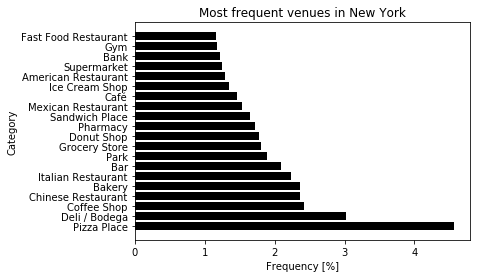

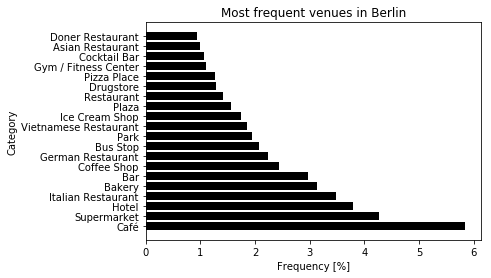

In [422]:
import matplotlib.pyplot as plt


y=np.arange(len(NY_counts.head(20)))
x=100*NY_counts.head(20)/NY_unique_venues.shape[0]
plt.barh(y,x,align='center', alpha=1, color='black')
plt.yticks(np.arange(len(NY_counts.head(20))), NY_counts.keys()[0:20])
plt.ylabel('Category')
plt.xlabel('Frequency [%]')
plt.title('Most frequent venues in New York')
plt.show()


y=np.arange(len(Berlin_counts.head(20)))
x=100*Berlin_counts.head(20)/Berlin_unique_venues.shape[0]
plt.barh(y,x,align='center', alpha=1, color='black')
plt.yticks(np.arange(len(Berlin_counts.head(20))), Berlin_counts.keys()[0:20])
plt.ylabel('Category')
plt.xlabel('Frequency [%]')
plt.title('Most frequent venues in Berlin')
plt.show()



Now, let's also visualize Berlin's and New York's most specific categories

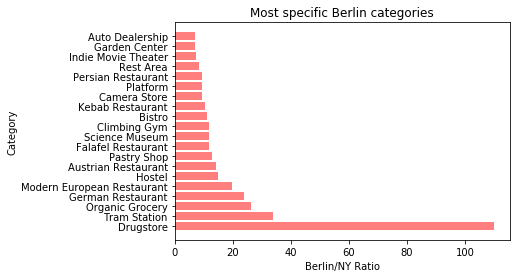

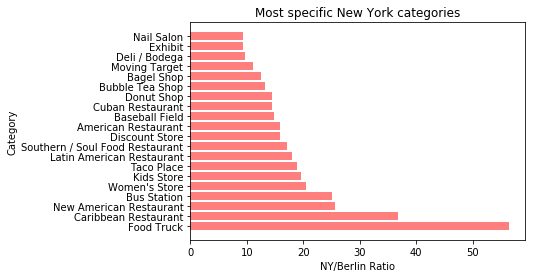

In [424]:
x=Berlin_stats_clean.sort_values(by ='Berlin/NY Ratio' , ascending=False).head(20)['Berlin/NY Ratio']
y=np.arange(len(Berlin_stats_clean.sort_values(by ='Berlin/NY Ratio' , ascending=False).head(20)))
plt.barh(y,x,align='center', alpha=0.5, color='red')
plt.yticks(np.arange(len(y)), Berlin_stats_clean.sort_values(by ='Berlin/NY Ratio' , ascending=False).head(20)['Category'])
plt.ylabel('Category')
plt.xlabel('Berlin/NY Ratio')
plt.title('Most specific Berlin categories')
plt.show()


x=NY_stats_clean.sort_values(by ='NY/Berlin Ratio' , ascending=False).head(20)['NY/Berlin Ratio']
y=np.arange(len(NY_stats_clean.sort_values(by ='NY/Berlin Ratio' , ascending=False).head(20)))
plt.barh(y,x,align='center', alpha=0.5, color='red')
plt.yticks(np.arange(len(y)), NY_stats_clean.sort_values(by ='NY/Berlin Ratio' , ascending=False).head(20)['Category'])
plt.ylabel('Category')
plt.xlabel('NY/Berlin Ratio')
plt.title('Most specific New York categories')
plt.show()



## 4. Discussion

In this analysis, the differences between German and US cities has been examined. The analysis shows some interesting results. Some of the results were expected, some were not.
In the following section three areas shall be analyzed closer.

### 4.1 Eating

Both cities show a high concentration of Italian Food ("Italian Restaurant", "Pizza Place"). So italian food seems to be pretty international. When it comes to asian food, New York has a high concentration of Chines Restaurants, whereas Berlin shows a higher concentration of Vietnamese Restaurants. 
Both cities show a high concentration of local restaurants ("German Restaurant", "American Restaurant"). Berlin shows the particularity to have many Turkish Restaurants ("Doener","Kebeb") whereas New York shows many "Mexican Restaurants".
In general both cities show a higher conentration of restaurants from "close-by" countries compared to the oter cities. So in Berlin "Austrian" Restaurants are common, compared to New York, but show low occurence in General.
The same applies for "Caribbean Restaurants" in New York

### 4.2 Supermarkets/Groceries

Supermarkets occur 3.4 more frequently in Berlin compared to New York. This can be explained by the size of supermarkets. In Germany one would rather find smaller supermarket but better distributed over the city, whereas the US shows bigger supermarkets bundled at certain locations.
This obersvation even holds true if you consider the category "Grocery store" along with the category "supermarket" in New York

### 4.3 Leisure Time

People in Berlin and New York seem to have different habbits when it comes to how they spend their leisure time. Parks and Gyms show an equal concentration in both cities.
However Germans seem to like Cafés more than Americans. This might be because of more frequent pedestrian zones in German cities.
In New York, Climbing Gyms seem quite rare. In Berlin the concentration is about ten times higher.
The opposite applies for Baseball fields, which are much more common in New York

## 5. Conclusion

The report shows the main differences and commonality between US and German Cities. 
Also it gives a look into the history of the city. For example vietnamese restaurants in Berlin are frequent because of good relationships of former eastern Germany and former socialist vietnam.
A further analysis of more US and German cities would be interesting to further prove the discovered results.


# Thanks for reading :)


